<a href="https://colab.research.google.com/github/vuongvmu/GoogleColabDemoCode/blob/main/%5BTF2%5DVae%20with%20mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

In [127]:

epochs=1000
batch_size=4096
input_shape=(28,28,1)
latent_dim=16
h_image,w_image=28,28

In [100]:

(X_train,y_train) , (X_test,y_test) = tf.keras.datasets.mnist.load_data()
X_train=X_train.reshape(60000,28,28,1).astype('float32')/255.0
X_test=X_test.reshape(10000,28,28,1).astype('float32')/255.0
y_train=y_train.astype('int32')
y_test=y_test.astype('int32')

In [101]:

train_dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
batch(batch_size).repeat()

test_dataset=tf.data.Dataset.from_tensor_slices((X_test,y_test)).\
batch(batch_size).repeat()

In [128]:
def conv_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2D(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)

def conv_transpose_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2DTranspose(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)


In [37]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [129]:
def model(input_shape,latent_dim):
  #Encoder
  model_input=tf.keras.Input(input_shape)
  layer=conv_layer(model_input,32,3)
  tf.keras.layers.BatchNormalization()(layer)
  layer=conv_layer(layer,16,3,strides=2)
  tf.keras.layers.BatchNormalization()(layer)
  layer=conv_layer(layer,32,3,strides=2)
  tf.keras.layers.BatchNormalization()(layer)
  shape_before_flatten=layer.shape
  layer=tf.keras.layers.Flatten()(layer)
  mean=tf.keras.layers.Dense(latent_dim)(layer)
  var=tf.keras.layers.Dense(latent_dim)(layer)
  encoder_model=tf.keras.models.Model(model_input,[mean,var])

  #Decoder
  decoder_input=tf.keras.Input((latent_dim,))
  layer=tf.keras.layers.Dense(np.prod(shape_before_flatten[1:]),\
                              activation='relu')(decoder_input)
  layer=tf.keras.layers.Reshape(target_shape=shape_before_flatten[1:])(layer)
  tf.keras.layers.BatchNormalization()(layer)
  layer=conv_transpose_layer(layer,32,3,strides=2)
  tf.keras.layers.BatchNormalization()(layer)
  layer=conv_transpose_layer(layer,16,3,strides=2)
  tf.keras.layers.BatchNormalization()(layer)
  layer=conv_transpose_layer(layer,1,3,activation='sigmoid')
  decoder_model=tf.keras.models.Model(decoder_input,layer)

  #Reparameterization Trick
  mean,var=encoder_model(model_input)
  epsilon=tf.random.normal(shape=(tf.shape(var)[0],
                                  tf.shape(var)[1]))
  # z=mean+tf.exp(var)*epsilon
  z=mean+tf.exp(0.5*var)*epsilon
  model_out=decoder_model(z)
  model=tf.keras.models.Model(model_input,model_out)

  #Reconstruction loss
  reconstruction_loss = K.sum(K.binary_crossentropy(model_input,model_out), axis=[1, 2, 3])

  # reconstruction_loss = K.sum(tf.keras.metrics.MeanSquaredError(model_input,model_out), axis=[1, 2, 3])

  #KL div loss
  kl_loss = - 0.5 * K.sum(1 + var - K.square(mean) - K.exp(var), axis=-1)

  elbo = K.mean(reconstruction_loss + kl_loss)
  model.add_loss(elbo)
  # model.summary()
  return model,decoder_model,encoder_model

In [130]:
vae_model,decoder_model,encoder_model=model(input_shape,latent_dim)

vae_model.compile(optimizer=tf.keras.optimizers.Adam(0.01,decay=0.05))

callback=[(tf.keras.callbacks.ModelCheckpoint(filepath='/content/mnist_model.h5',
                                            patience=0, verbose=0))]

vae_model.fit(train_dataset,epochs=epochs,callbacks=callback,
              steps_per_epoch=(len(X_train)//batch_size))
# vae_model.fit(x=X_train,epochs=epochs,callbacks=callback,batch_size=128)

Epoch 1/1000
14/14 [==============================] - 3s 17ms/step - loss: 332.9494
Epoch 2/1000
14/14 [==============================] - 0s 15ms/step - loss: 223.5669
Epoch 3/1000
14/14 [==============================] - 0s 14ms/step - loss: 216.1912
Epoch 4/1000
14/14 [==============================] - 0s 14ms/step - loss: 215.9978
Epoch 5/1000
14/14 [==============================] - 0s 14ms/step - loss: 206.3715
Epoch 6/1000
14/14 [==============================] - 0s 16ms/step - loss: 212.0301
Epoch 7/1000
14/14 [==============================] - 0s 15ms/step - loss: 208.5674
Epoch 8/1000
14/14 [==============================] - 0s 15ms/step - loss: 193.3924
Epoch 9/1000
14/14 [==============================] - 0s 15ms/step - loss: 184.7793
Epoch 10/1000
14/14 [==============================] - 0s 15ms/step - loss: 169.9116
Epoch 11/1000
14/14 [==============================] - 0s 16ms/step - loss: 162.4890
Epoch 12/1000
14/14 [==============================] - 0s 13ms/step - loss

1/1 [==============================] - 0s 18ms/step


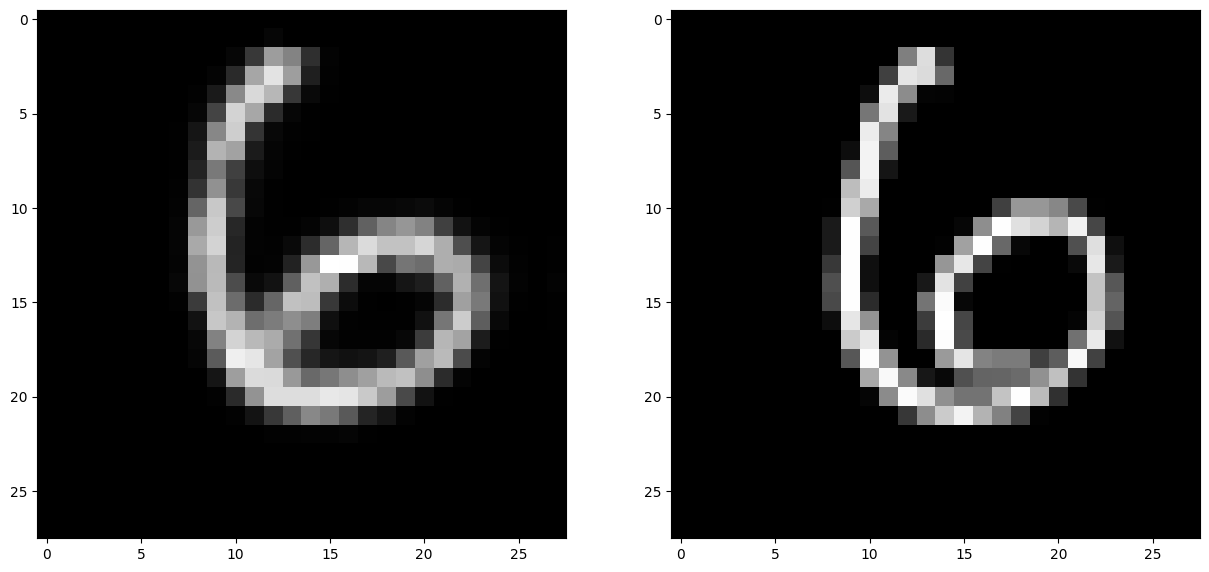

In [134]:
index=100

x_te=np.expand_dims(X_test[index],axis=0)
recontruct=vae_model.predict(x_te)
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(tf.reshape(recontruct,img_size),cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(tf.reshape(X_test[index],img_size),cmap='gray')
plt.show()


<ipython-input-137-17c4cb7334c5>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


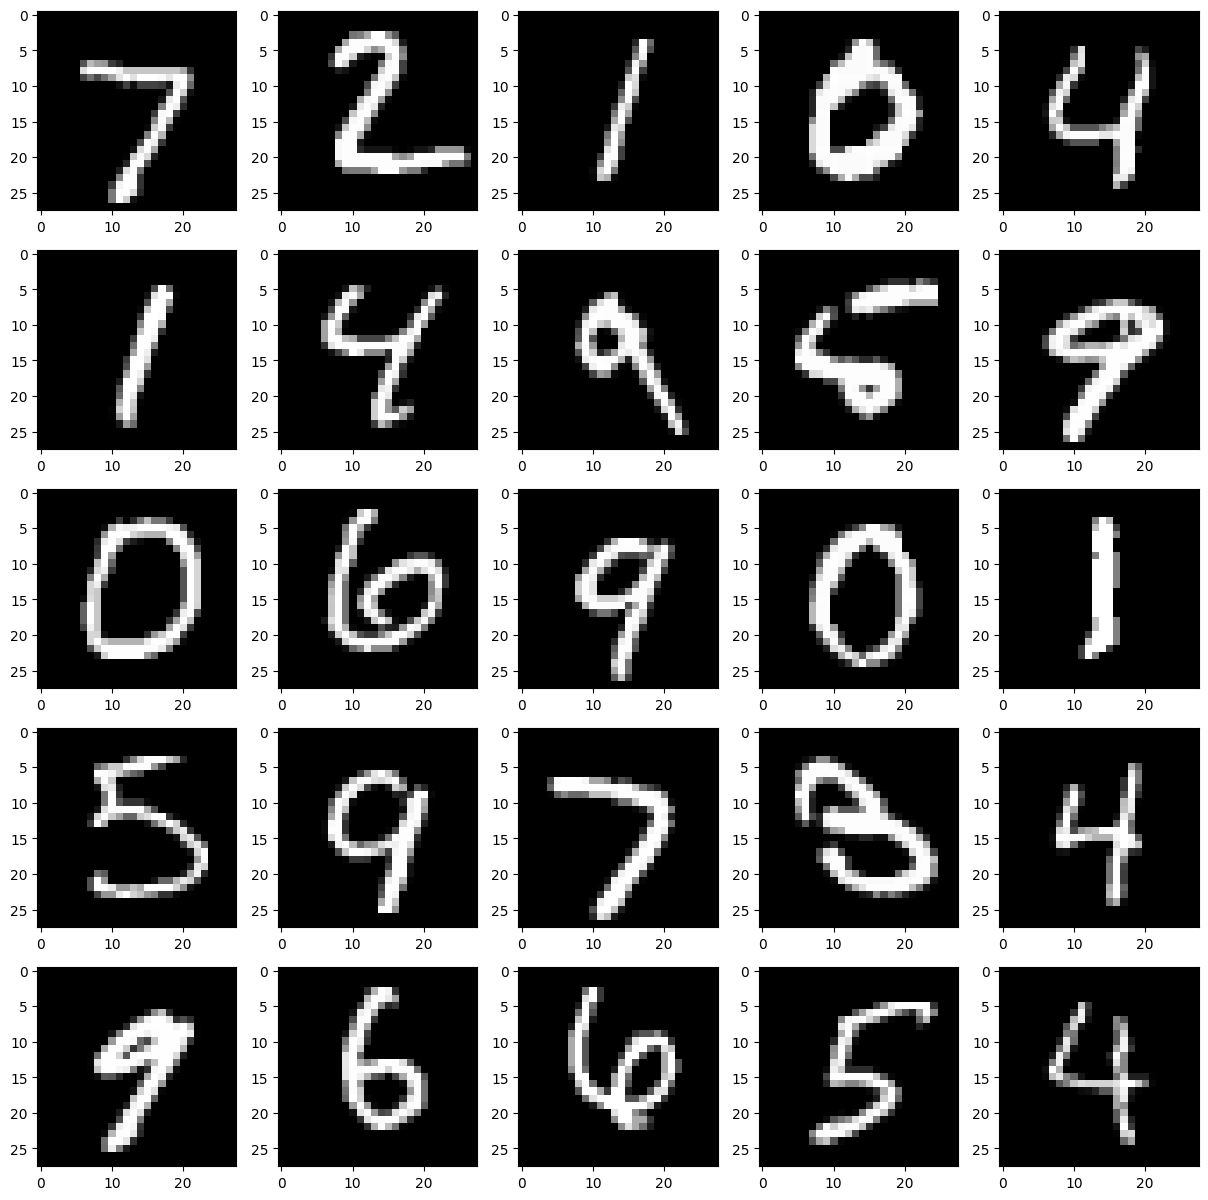

<ipython-input-137-17c4cb7334c5>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,5,i+1)


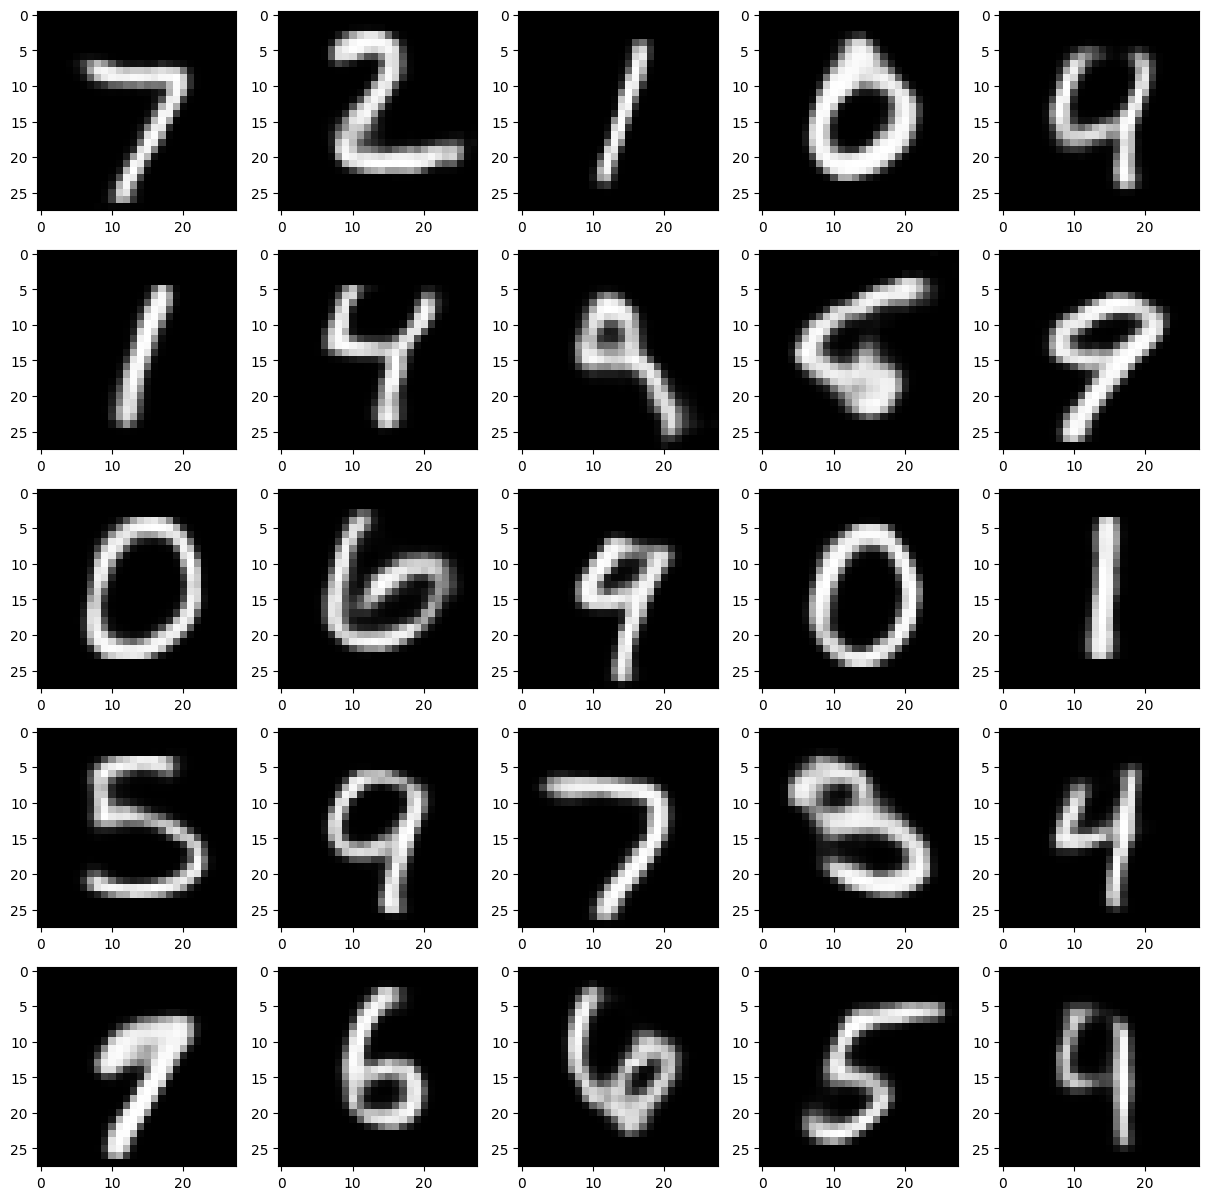

In [137]:

#Testing using decoder
model=tf.keras.models.load_model('/content/mnist_model.h5')
#Image generated
plt.figure(figsize=(15,15))
img_size=(h_image,w_image)
plt.title('Original image')
for i in range(25):
   for val in test_dataset.take(1):
     plt.subplot(5,5,i+1)
     plt.imshow(tf.reshape(val[0][i],img_size),cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.title('Recontruct image')
for i in range(25):
  for val in test_dataset.take(1):
    output=model.predict(np.expand_dims(val[0][i],axis=0),verbose=0)
    # z=encoder_model.predict(np.expand_dims(val[0][i],axis=0))
    # output=decoder_model.predict(z)
    output=tf.reshape(output,img_size)
    plt.subplot(5,5,i+1)
    plt.imshow(output,cmap='gray')
plt.show()